In [1]:
import tensorflow as tf
import keras
import config
import os
import argparse
import logging

from src import model
from src import preprocessing
from src import dataGenerator
from src import util
from src import model
import numpy as np
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:


physical_devices = tf.config.experimental.list_physical_devices('GPU')
assert len(physical_devices) > 0, "Not enough GPU hardware devices available"
_config = tf.config.experimental.set_memory_growth(physical_devices[0], True)


# Checking for param json folder and creating logging file
if not os.path.exists(config.pathParam):
    paramDict = config.modelParam
    util.save_json(paramDict, config.pathParam)

# Checking for logging folder and creating logging file
util.check_dir(config.pathLog)
util.set_logger(os.path.join(config.pathLog, 'train.log'))




In [3]:

###############################################################################
# Loading Parameters
assert os.path.isfile(
config.pathParam), "No json configuration for model found at {}".format(config.pathParam)

logging.info('Loading Parameters')
params = util.Params(config.pathParam)


Loading Parameters


In [4]:

# Training Data to Data Generator format
logging.info('Training Data to Data Generator format')
getTrainingData = dataGenerator.getData(pathImage=config.pathTraining)
trainingIndexes, trainingImageMap, trainingLabelMap = getTrainingData.getList()

logging.info('Creating Training Data Generator')
trainingGenerator = dataGenerator.DataGenerator(
list_IDs=trainingIndexes, imageMap=trainingImageMap, labelMap=trainingLabelMap, params=params, prediction=False, shuffle=True)


Training Data to Data Generator format
Creating Training Data Generator


In [5]:

# Validation Data to Data Generator format
getValidationData = dataGenerator.getData(pathImage=config.pathTesting)
validationIndexes, validationImageMap, validationLabelMap = getValidationData.getList()

logging.info('Validation data to Data Generator format')
validationGenerator = dataGenerator.DataGenerator(
list_IDs=validationIndexes, imageMap=validationImageMap, labelMap=validationLabelMap, params=params, prediction=False, shuffle=True)


Validation data to Data Generator format


In [6]:
import importlib
importlib.reload(model)

<module 'src.model' from '/home/manishpc/Downloads/tiler/retina/VisionEagle/src/model.py'>

In [7]:
for i, tg in enumerate(trainingGenerator):
    a, b = tg
    print('mean arr: {}, mean label: {}, counter: {}, a shape: {}, b shape: {}'.format(np.mean(a), np.mean(b), i, a.shape, b.shape))

mean arr: 0.32268238005295263, mean label: 0.75, counter: 0, a shape: (8, 512, 512, 3), b shape: (8, 1)
mean arr: 0.32302732841641285, mean label: 0.625, counter: 1, a shape: (8, 512, 512, 3), b shape: (8, 1)
mean arr: 0.256007737427755, mean label: 0.625, counter: 2, a shape: (8, 512, 512, 3), b shape: (8, 1)
mean arr: 0.28203162772982726, mean label: 0.875, counter: 3, a shape: (8, 512, 512, 3), b shape: (8, 1)
mean arr: 0.2965455878014656, mean label: 0.75, counter: 4, a shape: (8, 512, 512, 3), b shape: (8, 1)
mean arr: 0.2609347673802591, mean label: 0.5, counter: 5, a shape: (8, 512, 512, 3), b shape: (8, 1)
mean arr: 0.2961942242641074, mean label: 0.625, counter: 6, a shape: (8, 512, 512, 3), b shape: (8, 1)
mean arr: 0.28857347139346057, mean label: 0.875, counter: 7, a shape: (8, 512, 512, 3), b shape: (8, 1)
mean arr: 0.26972311057296466, mean label: 0.875, counter: 8, a shape: (8, 512, 512, 3), b shape: (8, 1)
mean arr: 0.24675076428581674, mean label: 0.5, counter: 9, a sh

In [8]:

# Initilizing Model
logging.info('Initializing Model')

# Model Training
path_save_callback = os.path.join(
config.pathOutputModel, 'weights.{epoch:02d}-{val_loss:.2f}.hdf5')
savingModel = keras.callbacks.ModelCheckpoint(path_save_callback,
                                           monitor='val_loss',
                                           verbose=0,
                                           save_best_only=False,
                                           save_weights_only=True,
                                           mode='auto',
                                           period=5)

csvLogger = keras.callbacks.CSVLogger(
    os.path.join(config.pathLog, 'trainingLog.csv'),  append=True)

retinaModel, retinaHeatMap = model.retinaModel(params)

logging.info('Compiling Model')
retinaModel.compile(optimizer=keras.optimizers.Adam(lr=params.learningRate),
                   loss='binary_crossentropy', metrics=['accuracy'])



Initializing Model
Input shape: (None, 512, 512, 3)
After Conv 0 shape: (None, 510, 510, 64)
After Max Pool 0 shape: (None, 255, 255, 64) 
After Conv 1 shape: (None, 253, 253, 128)
After Max Pool 1 shape: (None, 126, 126, 128) 
After Conv 2 shape: (None, 124, 124, 256)
After Max Pool 2 shape: (None, 62, 62, 256) 
After Conv 3 shape: (None, 60, 60, 512)
After Max Pool 3 shape: (None, 30, 30, 512) 
################### Heat Map Model #################
################### Label Prediction Model #################
Compiling Model


Patches Y: (None, 1)


In [9]:
retinaModel.summary()


Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 512, 512, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 510, 510, 64)      1792      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 255, 255, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 253, 253, 128)     73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 126, 126, 128)     0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 124, 124, 256)     295168    
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 62, 62, 256)       0   

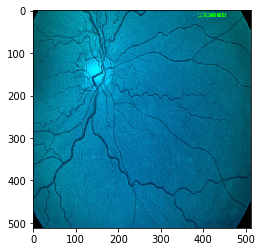

In [10]:
plt.imshow(np.array(trainingGenerator[11][0][0]*255, dtype=int))

In [11]:
history = retinaModel.fit_generator(generator=trainingGenerator,
                                   validation_data=validationGenerator,
                                   epochs=100,
                                   use_multiprocessing=True,
                                   workers=10,
                                   callbacks=[savingModel, csvLogger],
                                   verbose=1)

Epoch 1/100
76/76 [==============================] - 15s 202ms/step - loss: 0.7018 - accuracy: 0.6924 - val_loss: 0.5999 - val_accuracy: 0.7976
Epoch 2/100
76/76 [==============================] - 12s 160ms/step - loss: 0.6176 - accuracy: 0.7220 - val_loss: 0.5893 - val_accuracy: 0.7857
Epoch 3/100
76/76 [==============================] - 12s 157ms/step - loss: 0.6030 - accuracy: 0.7434 - val_loss: 0.6687 - val_accuracy: 0.7917
Epoch 4/100
76/76 [==============================] - 12s 159ms/step - loss: 0.5964 - accuracy: 0.7615 - val_loss: 0.6936 - val_accuracy: 0.7679
Epoch 5/100
Epoch 4/100
76/76 [==============================] - 12s 160ms/step - loss: 0.5893 - accuracy: 0.7615 - val_loss: 0.5252 - val_accuracy: 0.7917
Epoch 6/100
76/76 [==============================] - 12s 158ms/step - loss: 0.5985 - accuracy: 0.7401 - val_loss: 0.5184 - val_accuracy: 0.8095
Epoch 7/100
76/76 [==============================] - 12s 159ms/step - loss: 0.5960 - accuracy: 0.7484 - val_loss: 0.4542 - v

Process ForkPoolWorker-803:
Process ForkPoolWorker-796:
Process ForkPoolWorker-794:
Process ForkPoolWorker-807:
Process ForkPoolWorker-792:
Process ForkPoolWorker-802:
Process ForkPoolWorker-805:
Process ForkPoolWorker-800:
Process ForkPoolWorker-799:
Process ForkPoolWorker-797:
Process ForkPoolWorker-806:
Process ForkPoolWorker-791:
Process ForkPoolWorker-804:
Process ForkPoolWorker-801:
Process ForkPoolWorker-798:
Process ForkPoolWorker-793:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/manishpc/miniconda3/envs/py3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Process ForkPoolWorker-795:
  File "/home/manishpc/miniconda3/envs/py3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/home/manishpc/minico

  File "/home/manishpc/miniconda3/envs/py3/lib/python3.6/multiprocessing/queues.py", line 334, in get
    with self._rlock:
  File "/home/manishpc/miniconda3/envs/py3/lib/python3.6/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/home/manishpc/miniconda3/envs/py3/lib/python3.6/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/home/manishpc/miniconda3/envs/py3/lib/python3.6/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
  File "/home/manishpc/miniconda3/envs/py3/lib/python3.6/multiprocessing/queues.py", line 334, in get
    with self._rlock:
  File "/home/manishpc/miniconda3/envs/py3/lib/python3.6/multiprocessing/connection.py", line 216, in recv_bytes
    buf = self._recv_bytes(maxlength)
KeyboardInterrupt
  File "/home/manishpc/miniconda3/envs/py3/lib/python3.6/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
  File "/home/manishpc/miniconda3/envs/py3/li

KeyboardInterrupt: 

In [12]:
logging.info('Saving Last model...')
pathTrainedRetinaModel = os.path.join(config.pathOutputModel, 'retinaModel.h5')
pathTrainedHeatMapModel = os.path.join(config.pathOutputModel, 'heatMapModel.h5')


retinaModel.save(pathTrainedRetinaModel)
retinaHeatMap.save(pathTrainedHeatMapModel)
logging.info('Retina Model: {}, HeatMap Model: {}'.format(pathTrainedRetinaModel, pathTrainedHeatMapModel))


Saving Last model...
Retina Model: experiments/1/model/retinaModel.h5, HeatMap Model: experiments/1/model/heatMapModel.h5


In [41]:
import cv2

In [84]:
retinaModel.evaluate_generator(validationGenerator, verbose=1)

21/21 [==============================] - 1s 50ms/step


[0.8559132218360901, 0.8571428656578064]

In [43]:
pred = []
img = []
lb = []
for tdg in validationGenerator:
    img1, lb1 = tdg[0], tdg[1]
    pred.append(retinaHeatMap.predict(img1))
    img.append(img1)
    lb.append(lb1)

In [79]:
count = 0
for i in range(len(pred)):
    for j in range(len(pred[i])):
        temp_label = lb[i][j]
        temp_img = img[i][j]
        temp_heat = cv2.resize(pred[i][j][:, :, 0], (512, 512))
        temp_heat = cv2.cvtColor(temp_heat, cv2.COLOR_GRAY2RGB)
        cv2.imwrite(os.path.join(config.pathOutputHeatMap, str(count) + '_heat_p{}.jpg'), temp_heat*255)
        cv2.imwrite(os.path.join(config.pathOutputHeatMap, str(count) + '_img_p{}.jpg'), temp_img * 255)
        count +=1

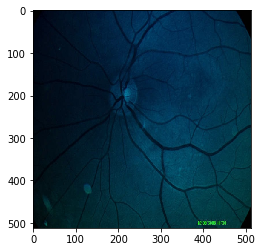

In [75]:
plt.imshow(temp_img)

In [82]:
lb1[1]

array([1])